### EDA

In [28]:
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np 
import os

# Optional: set the Seaborn theme
sns.set(style="whitegrid")

In [2]:
# Define your DB credentials
host = 'localhost'         # or your remote server
port = '5432'              # default PostgreSQL port
database = 'electronic_rfm'
user = 'admin'
password = 'admin'

In [3]:
# Create connection string
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

# Load your dbt model table — e.g., mart_rfm
mart_rfm = pd.read_sql('SELECT * FROM public_analytics.mart_rfm', engine)

# Check your data
mart_rfm.head()

,customer_id,recency_days,frequency,monetary,loyalty_member,recency_score,frequency_score,monetary_score,rfm_total_score,total_revenue
0,15639,0,2,14189.17,False,1,1,1,3,14245.23
1,2839,0,1,186.75,False,1,3,5,9,240.61
2,1038,0,4,14976.71,True,1,1,1,3,15060.66
3,14264,0,2,12480.34,True,1,1,1,3,12727.57
4,11827,0,2,14647.42,True,1,1,1,3,14976.83


### Plot distributions of recency_days, frequency, monetary, rfm_score

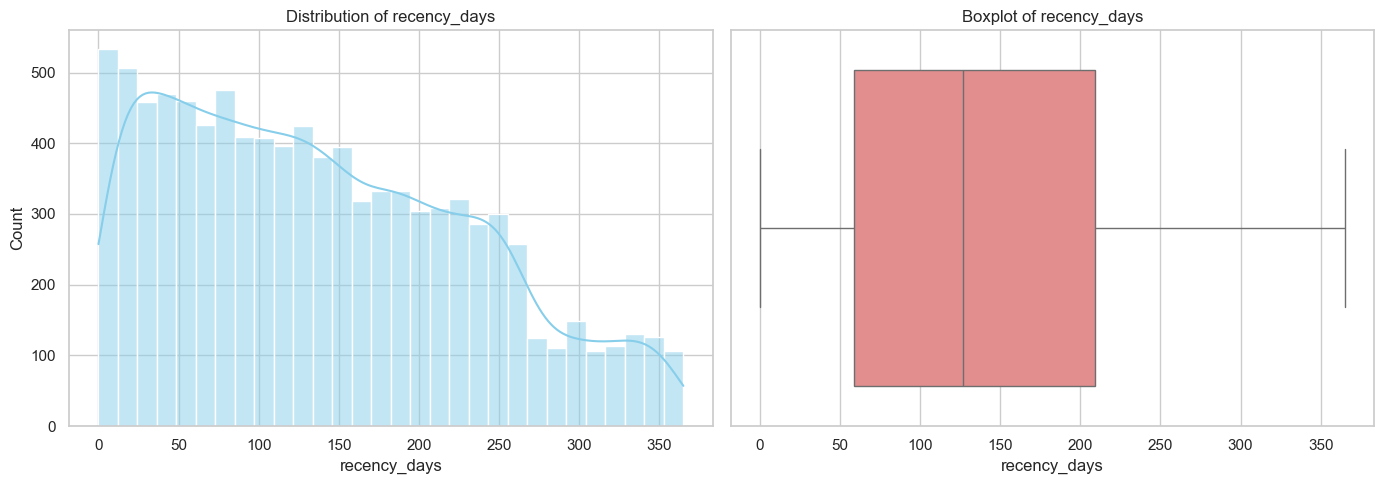

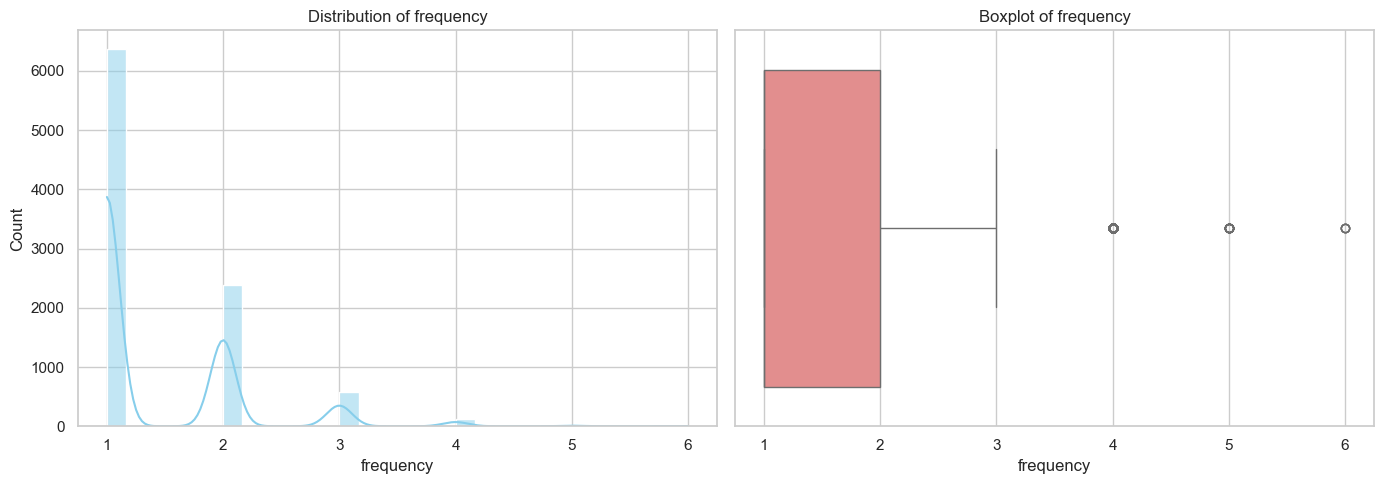

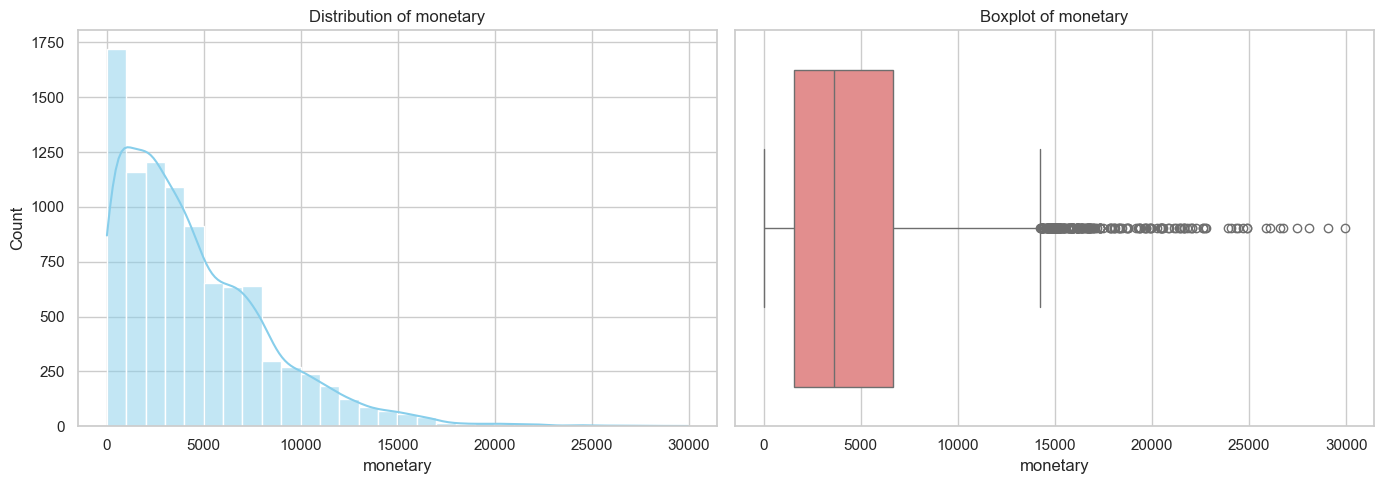

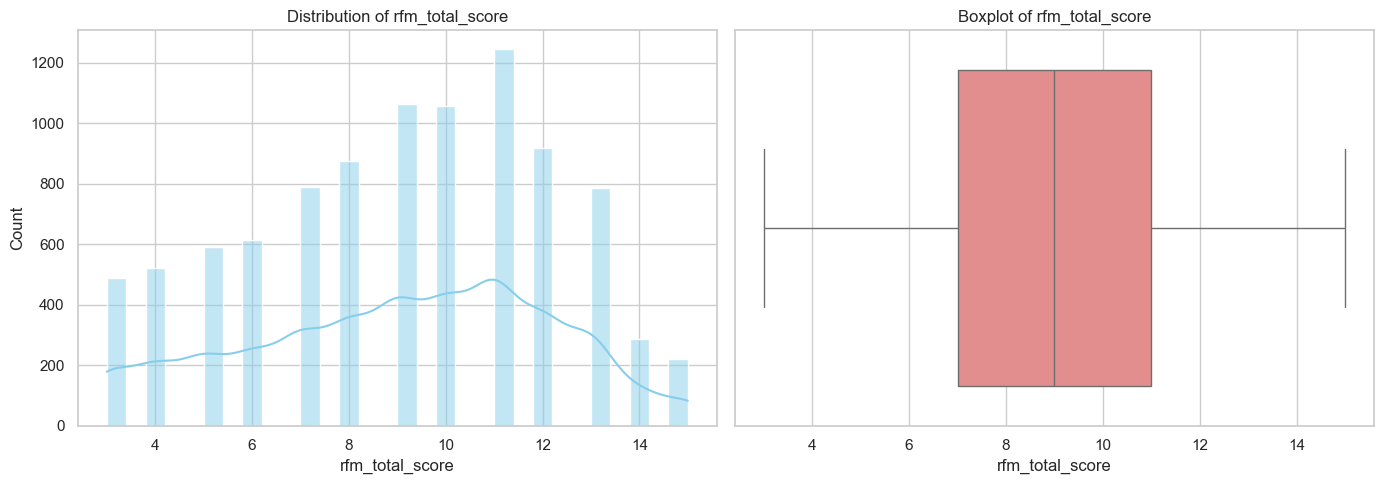

In [4]:
# List of RFM-related columns
rfm_columns = ['recency_days', 'frequency', 'monetary', 'rfm_total_score']

# Loop through each column
for col in rfm_columns:
    if col not in mart_rfm.columns:
        print(f"Column '{col}' not found, skipping...")
        continue

    plt.figure(figsize=(14, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(mart_rfm[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=mart_rfm[col], color='lightcoral')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    # Save the figure before showing it
    filename = f'{col}_distribution_plot.png'
    plt.savefig(f"../image/{filename}", dpi=300)

    plt.tight_layout()
    plt.show()

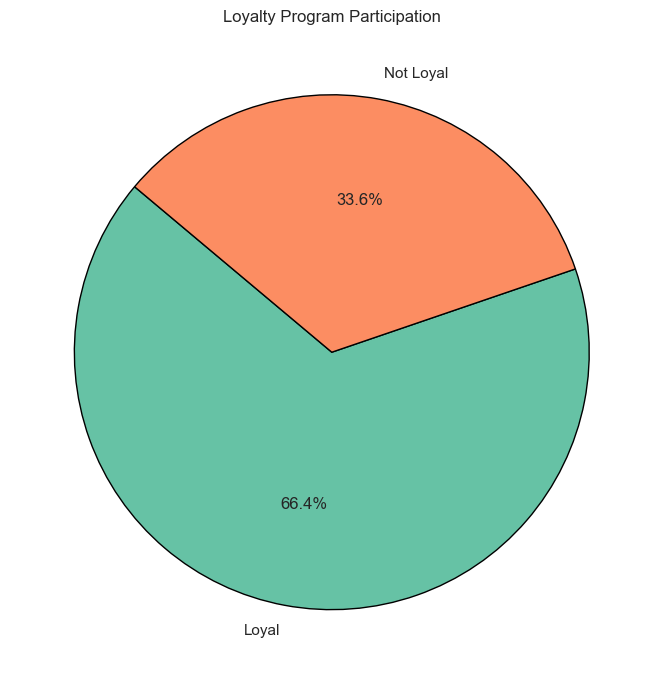

In [5]:
# Pie Chart of Loyalty Status

plt.figure(figsize=(7, 7))
loyalty_counts = mart_rfm['loyalty_member'].value_counts()
labels = ['Loyal', 'Not Loyal'] if sorted(mart_rfm['loyalty_member'].unique()) == [0, 1] else loyalty_counts.index
colors = ['#66c2a5', '#fc8d62']

plt.pie(loyalty_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title("Loyalty Program Participation")
plt.tight_layout()
plt.savefig("../image/loyalty_distribution_pie.png", dpi=300)
plt.show()

#### Correlation Analysis

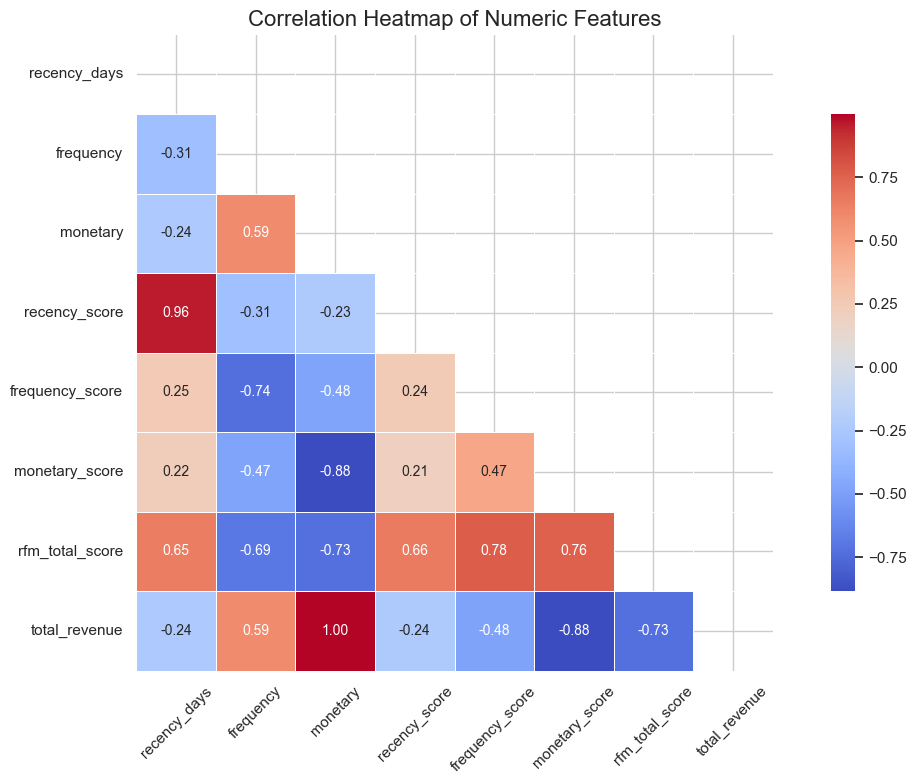

In [6]:
# Select only numeric columns
numeric_df = mart_rfm.select_dtypes(include=[np.number]).drop(columns=['customer_id'], errors='ignore')

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Draw the heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75},
    annot_kws={"size": 10}
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig("../image/Correlation Heatmap.png", dpi=300)
plt.show()

#### Outliers Detection

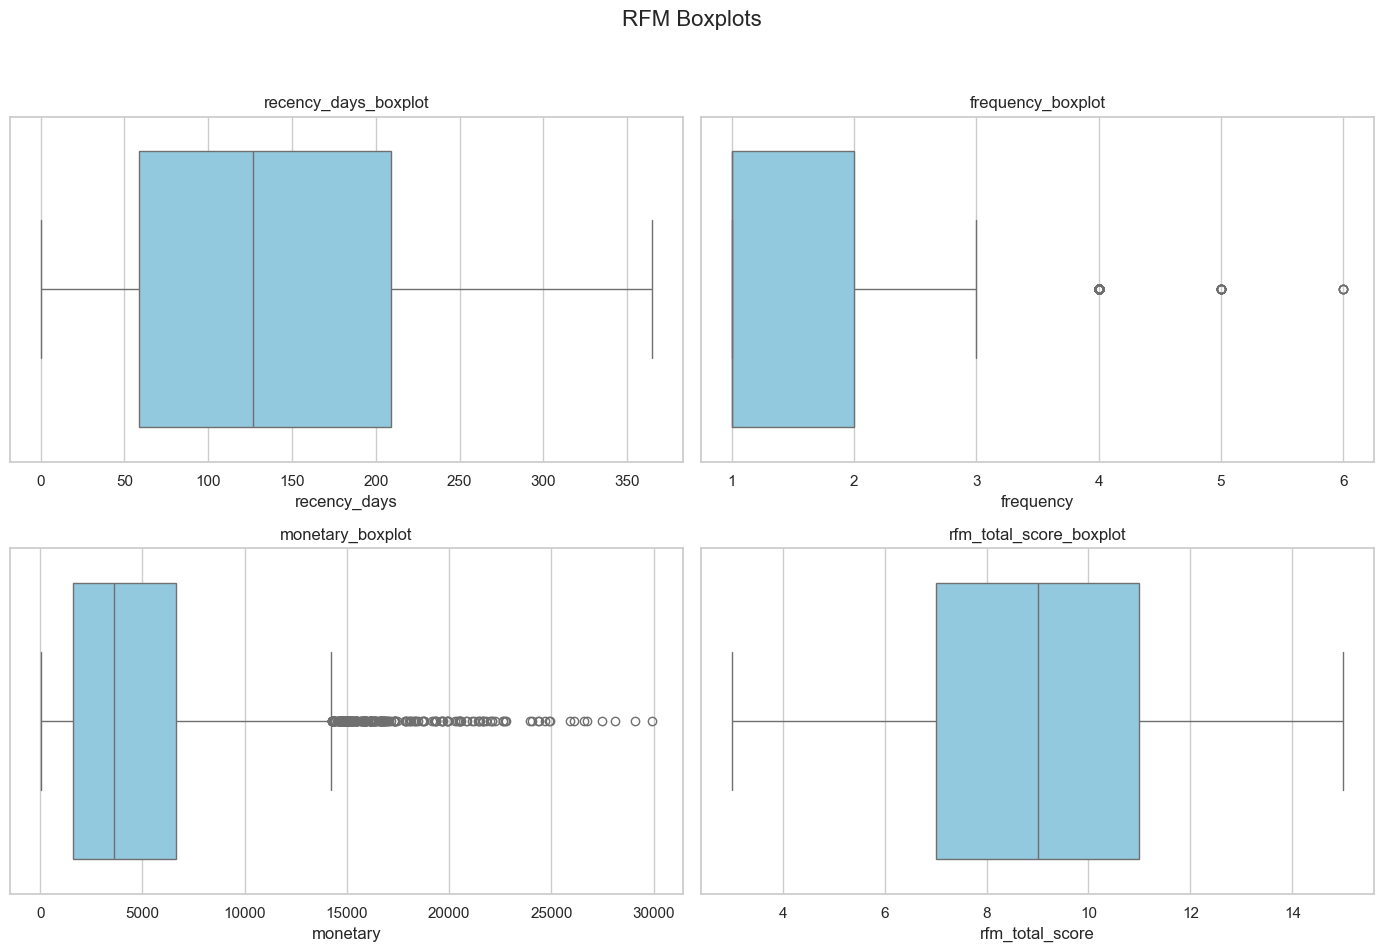

In [7]:
# Columns to plot
rfm_columns = ['recency_days', 'frequency', 'monetary', 'rfm_total_score']

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('RFM Boxplots', fontsize=16)

# Flatten axes for iteration
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(rfm_columns):
    sns.boxplot(x=mart_rfm[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'{col}_boxplot', fontsize=12)
    axes[i].set_xlabel(col)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig("../image/RFM_Boxplot.png", dpi=300)
plt.show()

### Time Trend Analysis

In [11]:
# Load dbt model table 
staging_table = pd.read_sql('SELECT * FROM public_staging.stg_sale_data', engine)

# Check your data
staging_table.head()

,customer_id,age,gender,loyalty_member,is_loyal_customer,product_type,sku,rating,order_status,payment_method,shipping_type,add_ons_purchased,total_price,unit_price,quantity,purchase_date,add_on_total
0,1000,53,male,no,False,smartphone,SKU1004,2,cancelled,credit card,standard,"accessory,accessory,accessory",5538.33,791.19,7,2024-03-20,40.21
1,1000,53,male,no,False,tablet,SKU1002,3,completed,paypal,overnight,impulse item,741.09,247.03,3,2024-04-20,26.09
2,1002,41,male,no,False,laptop,SKU1005,3,completed,credit card,express,None,1855.84,463.96,4,2023-10-17,0.00
3,1002,41,male,yes,True,smartphone,SKU1004,2,completed,cash,overnight,"impulse item,impulse item",3164.76,791.19,4,2024-08-09,60.16
4,1003,75,male,yes,True,smartphone,SKU1001,5,completed,cash,express,accessory,41.50,20.75,2,2024-05-21,35.56


In [24]:
staging_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        20000 non-null  int64  
 1   age                20000 non-null  int64  
 2   gender             20000 non-null  object 
 3   loyalty_member     20000 non-null  object 
 4   is_loyal_customer  20000 non-null  bool   
 5   product_type       20000 non-null  object 
 6   sku                20000 non-null  object 
 7   rating             20000 non-null  int64  
 8   order_status       20000 non-null  object 
 9   payment_method     20000 non-null  object 
 10  shipping_type      20000 non-null  object 
 11  add_ons_purchased  15132 non-null  object 
 12  total_price        20000 non-null  float64
 13  unit_price         20000 non-null  float64
 14  quantity           20000 non-null  int64  
 15  purchase_date      20000 non-null  object 
 16  add_on_total       200

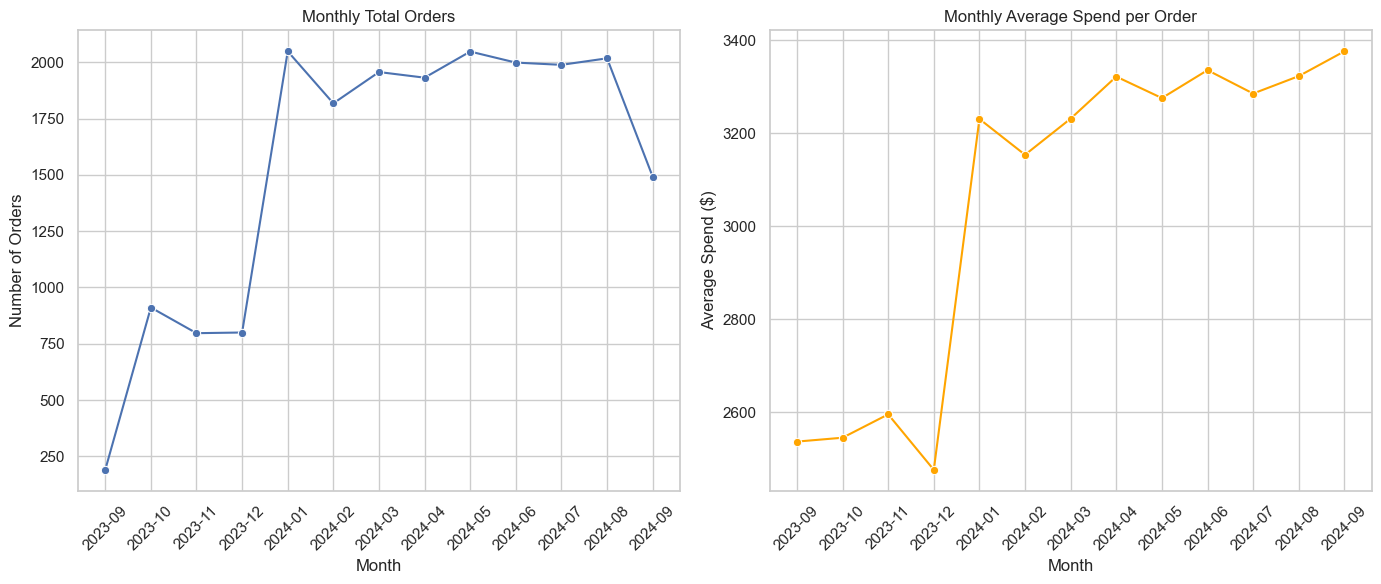

In [26]:
# Convert 'purchase_date' to datetime
staging_table['purchase_date'] = pd.to_datetime(staging_table['purchase_date'])

# Create 'year_month' column for aggregation
staging_table['year_month'] = staging_table['purchase_date'].dt.to_period('M').astype(str)

# Group by 'year_month'
monthly_metrics = staging_table.groupby('year_month').agg(
    total_orders=('customer_id', 'count'),                # total number of orders
    total_revenue=('total_price', 'sum'),                 # total revenue
    average_spend_per_order=('total_price', 'mean')       # average spend per order
).reset_index()

# Set plot style
sns.set(style='whitegrid')
plt.figure(figsize=(14, 6))

# Plot Total Orders
plt.subplot(1, 2, 1)
sns.lineplot(data=monthly_metrics, x='year_month', y='total_orders', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Total Orders')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

# Plot Average Spend per Order
plt.subplot(1, 2, 2)
sns.lineplot(data=monthly_metrics, x='year_month', y='average_spend_per_order', marker='o', color='orange')
plt.xticks(rotation=45)
plt.title('Monthly Average Spend per Order')
plt.xlabel('Month')
plt.ylabel('Average Spend ($)')

plt.tight_layout()
plt.savefig("../image/Time Trend Analysis.png", dpi=300)
plt.show()

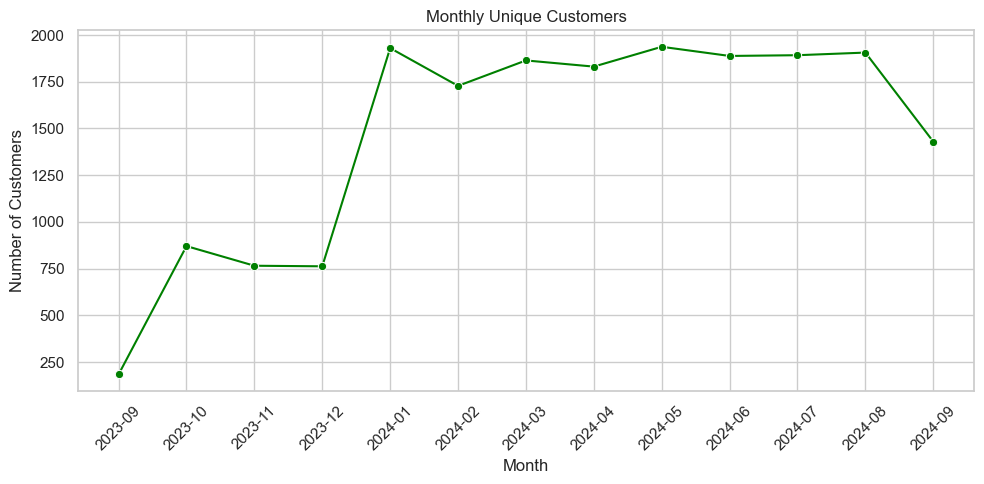

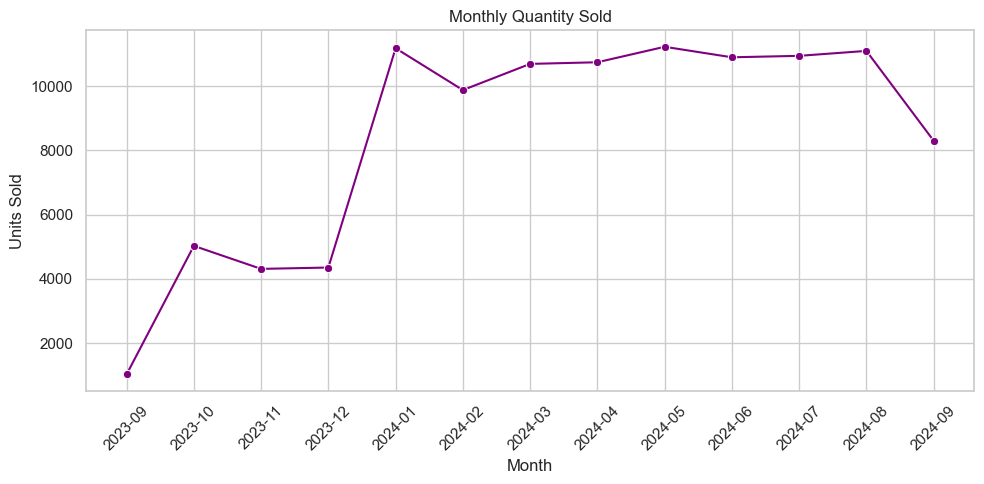

In [32]:
# Convert to datetime if not already
staging_table['purchase_date'] = pd.to_datetime(staging_table['purchase_date'])

# Create 'Month' column for grouping
staging_table['Month'] = staging_table['purchase_date'].dt.to_period('M').astype(str)

# Group by Month
monthly_metrics = staging_table.groupby('Month').agg({
    'customer_id': pd.Series.nunique,    
    'total_price': ['sum', 'mean'],      
    'quantity': 'sum',                  
    'purchase_date': 'count'             
}).reset_index()

# Rename columns for easier plotting
monthly_metrics.columns = ['Month', 'Unique_Customers', 'Total_Spend', 'Avg_Spend_per_Order', 'Quantity_Sold', 'Total_Orders']

# ---------- Save Unique Customers plot ----------
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_metrics, x='Month', y='Unique_Customers', marker='o', color='green')
plt.title('Monthly Unique Customers')
plt.xticks(rotation=45)
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.savefig('../image/monthly_unique_customers.png', dpi=300)
plt.show()
plt.close()  # Close the figure to avoid overlap

# ---------- Save Quantity Sold plot ----------
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_metrics, x='Month', y='Quantity_Sold', marker='o', color='purple')
plt.title('Monthly Quantity Sold')
plt.xticks(rotation=45)
plt.ylabel('Units Sold')
plt.tight_layout()
plt.savefig('../image/monthly_quantity_sold.png', dpi=300)
plt.show()
plt.close()  # Close the figure to avoid overlap


### Gap Analysis & Hypothesis Generation

#### Statistically Detect Outliers (IQR Method)

In [140]:
Q1 = mart_rfm['monetary'].quantile(0.25)
Q3 = mart_rfm['monetary'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

outliers = mart_rfm[mart_rfm['monetary'] > upper_bound]

print(f"Number of outliers: {len(outliers)}")
print(f"Percentage: {len(outliers) / len(mart_rfm) * 100:.2f}%")
print(f"Max Monetary Value: {mart_rfm['monetary'].max()}")
print(f"Median Monetary Value: {mart_rfm['monetary'].median()}")

Number of outliers: 234
Percentage: 2.47%
Max Monetary Value: 29937.93
Median Monetary Value: 3610.26


#### Are there patterns in behavior for different product_type or payment_method?

In [46]:
# Group by payment_method
payment_metrics = staging_table.groupby('payment_method').agg({
    'customer_id': pd.Series.nunique,   # Number of unique customers
    'total_price': ['sum', 'mean'],     # Total and average spend
    'quantity': ['sum', 'mean'],        # Total and average quantity
    'purchase_date': 'count'            # Total number of orders
}).reset_index()

# Rename the columns for clarity
payment_metrics.columns = ['payment_method', 'Unique_Customers', 'Total_Spend', 'Avg_Spend',
                           'Total_Quantity', 'Avg_Quantity', 'Total_Orders']

In [43]:
# Group by product_type
product_metrics = staging_table.groupby('product_type').agg({
    'customer_id': pd.Series.nunique,   # Number of unique customers
    'total_price': ['sum', 'mean'],     # Total and average spend
    'quantity': ['sum', 'mean'],        # Total and average quantity
    'purchase_date': 'count'            # Total number of orders
}).reset_index()

product_metrics.columns = ['product_type', 'Unique_Customers', 'Total_Spend', 'Avg_Spend',
                           'Total_Quantity', 'Avg_Quantity', 'Total_Orders']

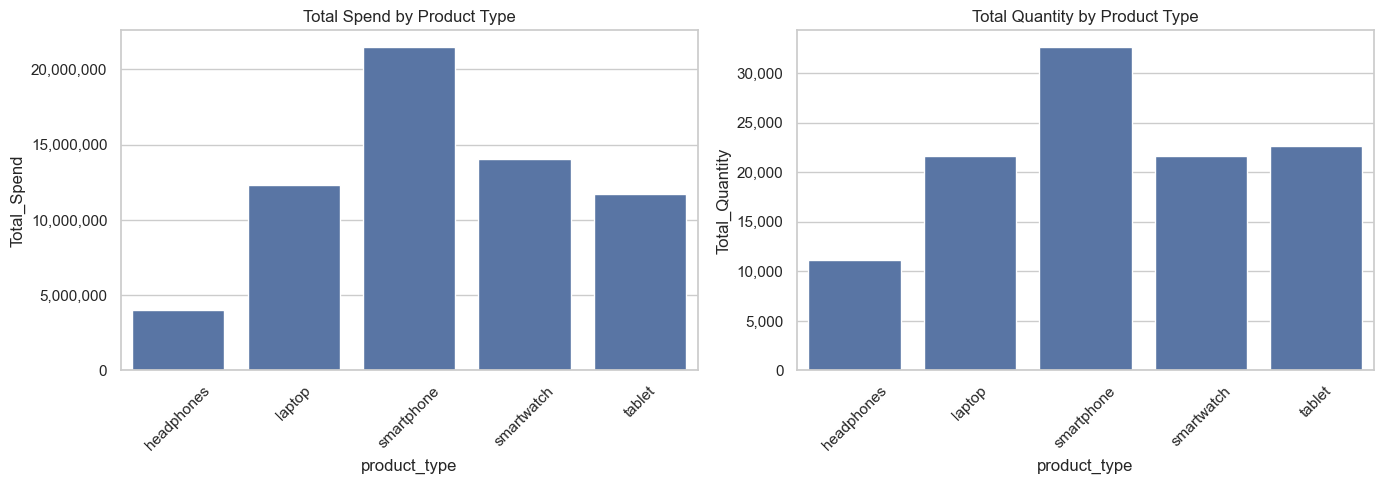

In [49]:
# Define a formatter for real number formatting
def currency_format(x, _):
    return f'{x:,.0f}'  # No decimal places, comma as thousand separator

plt.figure(figsize=(14, 5))

# Plot 1: Total Spend by Product Type
plt.subplot(1, 2, 1)
sns.barplot(data=product_metrics, x='product_type', y='Total_Spend')
plt.title('Total Spend by Product Type')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format))  

# Plot 2: Total Quantity by Product Type
plt.subplot(1, 2, 2)
sns.barplot(data=product_metrics, x='product_type', y='Total_Quantity')
plt.title('Total Quantity by Product Type')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))  

plt.tight_layout()
plt.savefig('../image/Spend & Quantity Product Type.png', dpi=300)
plt.show()

/var/folders/qw/mns0z74d3t1_nqjy7zgm7mkw0000gn/T/ipykernel_38825/1009362039.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_metrics, x='payment_method', y='Total_Spend', palette='Blues_d')
/var/folders/qw/mns0z74d3t1_nqjy7zgm7mkw0000gn/T/ipykernel_38825/1009362039.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=payment_metrics, x='payment_method', y='Total_Quantity', palette='Greens_d')


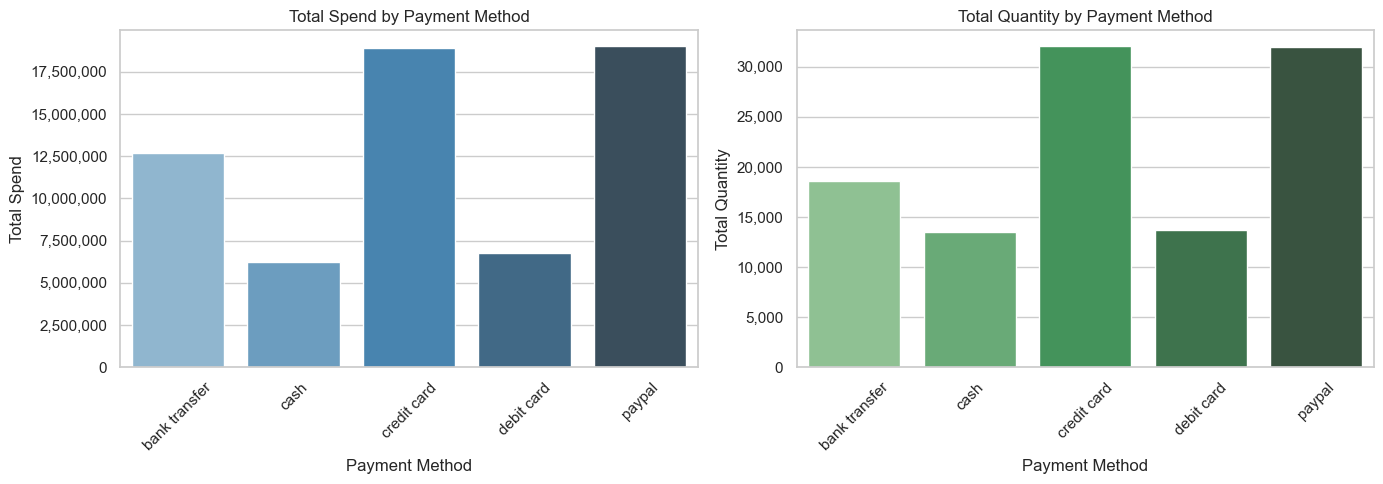

In [50]:
# GROUP BY payment_method
payment_metrics = staging_table.groupby('payment_method').agg({
    'customer_id': pd.Series.nunique,   # Unique customers
    'total_price': ['sum', 'mean'],     # Total and average spend
    'quantity': ['sum', 'mean'],        # Total and average quantity
    'purchase_date': 'count'            # Total number of orders
}).reset_index()

# RENAME COLUMNS
payment_metrics.columns = ['payment_method', 'Unique_Customers', 'Total_Spend', 'Avg_Spend',
                           'Total_Quantity', 'Avg_Quantity', 'Total_Orders']

# Format y-axis as readable numbers
def currency_format(x, _):
    return f'{x:,.0f}'

# PLOTTING
plt.figure(figsize=(14, 5))

# Total Spend by Payment Method
plt.subplot(1, 2, 1)
sns.barplot(data=payment_metrics, x='payment_method', y='Total_Spend', palette='Blues_d')
plt.title('Total Spend by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Spend')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format))

# Total Quantity by Payment Method
plt.subplot(1, 2, 2)
sns.barplot(data=payment_metrics, x='payment_method', y='Total_Quantity', palette='Greens_d')
plt.title('Total Quantity by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_format))

# Show the Plot
plt.tight_layout()
plt.savefig('../image/Spend & Quantity Payment_Method.png', dpi=300)
plt.show()

/var/folders/qw/mns0z74d3t1_nqjy7zgm7mkw0000gn/T/ipykernel_20651/856598635.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = mart_rfm.groupby(['recency_bucket', 'freq_bucket'])['monetary'].mean().reset_index()


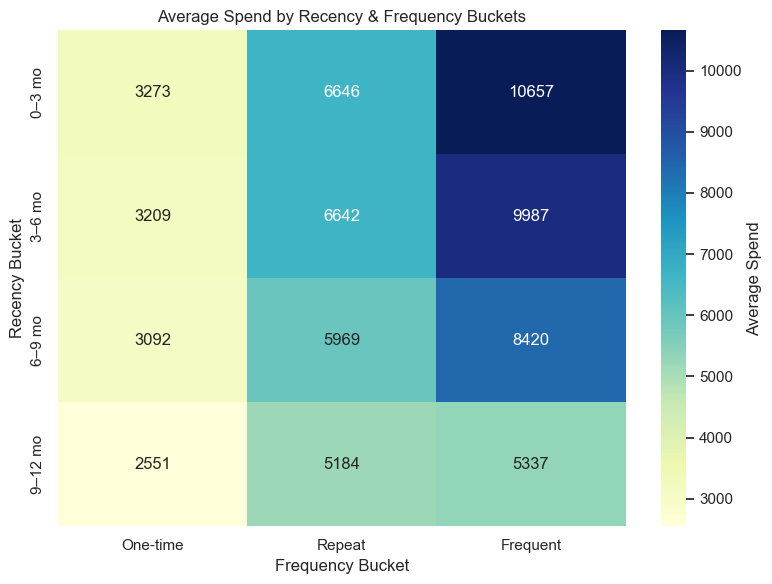

In [8]:
# Recency buckets: 0–90, 91–180, 181–270, 271–365
mart_rfm['recency_bucket'] = pd.cut(
    mart_rfm['recency_days'],
    bins=[0, 90, 180, 270, 365],
    labels=['0–3 mo', '3–6 mo', '6–9 mo', '9–12 mo'],
    include_lowest=True
)

# Frequency buckets: One-time, Repeat, Frequent
mart_rfm['freq_bucket'] = pd.cut(
    mart_rfm['frequency'],
    bins=[0, 1, 2, mart_rfm['frequency'].max()],
    labels=['One-time', 'Repeat', 'Frequent'],
    include_lowest=True
)

# Group and compute average spend
df = mart_rfm.groupby(['recency_bucket', 'freq_bucket'])['monetary'].mean().reset_index()

# Pivot to prepare for heatmap
heatmap_data = df.pivot(index='recency_bucket', columns='freq_bucket', values='monetary')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Average Spend'})
plt.title("Average Spend by Recency & Frequency Buckets")
plt.ylabel("Recency Bucket")
plt.xlabel("Frequency Bucket")
plt.tight_layout()
plt.savefig("../image/Heatmap_Mart_RFM.png", dpi = 300)
plt.show()

### FEATURES ENGINEER

In [9]:
# Add churn flag based on recency buckets
# flag customers in the 9–12 months bucket as churned.
mart_rfm['is_churned'] = mart_rfm['recency_bucket'] == '9–12 mo'

# Quick check: count churned vs non-churned
print(mart_rfm['is_churned'].value_counts())

is_churned
False    8530
True      936
Name: count, dtype: int64


In [148]:
mart_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   customer_id      9466 non-null   int64   
 1   recency_days     9466 non-null   int64   
 2   frequency        9466 non-null   int64   
 3   monetary         9466 non-null   float64 
 4   loyalty_member   9466 non-null   bool    
 5   recency_score    9466 non-null   int64   
 6   frequency_score  9466 non-null   int64   
 7   monetary_score   9466 non-null   int64   
 8   rfm_total_score  9466 non-null   int64   
 9   recency_bucket   9466 non-null   category
 10  freq_bucket      9466 non-null   category
 11  is_churned       9466 non-null   bool    
dtypes: bool(2), category(2), float64(1), int64(7)
memory usage: 629.1 KB


#### PRODUCT DIVERSITY FEARTURES

In [12]:
# Calculate product_diversity: number of unique product types per customer
product_diversity = (
    staging_table.groupby('customer_id')['product_type']
    .nunique()
    .reset_index()
    .rename(columns={'product_type': 'product_diversity'})
)

#### AVERAGE RATING

In [13]:
# Calculate avg_rating: average product rating per customer
avg_rating = (
    staging_table.groupby('customer_id')['rating']
    .mean()
    .reset_index()
    .rename(columns={'rating': 'avg_rating'})
)

In [14]:
# Merge both new features
new_features = product_diversity.merge(avg_rating, on='customer_id', how='left')

In [15]:
# Merge into mart_rfm
mart_rfm = mart_rfm.merge(new_features, on='customer_id', how='left')

# Fill missing avg_rating with 0 or another value
mart_rfm['avg_rating'] = mart_rfm['avg_rating'].fillna(0)

#### BASKET SIZE

In [16]:
# Avoid division by zero in basket_size by replacing 0 frequency with NaN (or a small value)
mart_rfm['basket_size'] = mart_rfm['monetary'] / mart_rfm['frequency'].replace(0, pd.NA)

# Fill NaN basket sizes (due to 0 frequency) with 0 or another strategy
mart_rfm['basket_size'] = mart_rfm['basket_size'].fillna(0)

In [17]:
mart_rfm.head()

,customer_id,recency_days,frequency,monetary,loyalty_member,recency_score,frequency_score,monetary_score,rfm_total_score,total_revenue,recency_bucket,freq_bucket,is_churned,product_diversity,avg_rating,basket_size
0,15639,0,2,14189.17,False,1,1,1,3,14245.23,0–3 mo,Repeat,False,2,4.00,7094.5850
1,2839,0,1,186.75,False,1,3,5,9,240.61,0–3 mo,One-time,False,1,5.00,186.7500
2,1038,0,4,14976.71,True,1,1,1,3,15060.66,0–3 mo,Frequent,False,2,3.25,3744.1775
3,14264,0,2,12480.34,True,1,1,1,3,12727.57,0–3 mo,Repeat,False,2,2.00,6240.1700
4,11827,0,2,14647.42,True,1,1,1,3,14976.83,0–3 mo,Repeat,False,2,3.50,7323.7100


#### TENURE DAYS

In [18]:
# Ensure purchase_date is in datetime format
staging_table['purchase_date'] = pd.to_datetime(staging_table['purchase_date'])

# Group by customer_id and calculate first and last purchase date
tenure_df = (
    staging_table.groupby('customer_id')['purchase_date']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate tenure in days
tenure_df['tenure_days'] = (tenure_df['max'] - tenure_df['min']).dt.days

# Fill tenure_days = 0 if only one purchase
tenure_df['tenure_days'] = tenure_df['tenure_days'].fillna(0)

# Preview result
tenure_df.head()

,customer_id,min,max,tenure_days
0,1000,2024-03-20,2024-04-20,31
1,1002,2023-10-17,2024-08-09,297
2,1003,2024-05-21,2024-05-21,0
3,1004,2024-05-26,2024-05-26,0
4,1005,2024-01-30,2024-06-24,146


In [19]:
# merge it into a mart_rfm table 
mart_rfm = mart_rfm.merge(tenure_df[['customer_id', 'tenure_days']], on='customer_id', how='left')

# show a result
mart_rfm.head()

,customer_id,recency_days,frequency,monetary,loyalty_member,recency_score,frequency_score,monetary_score,rfm_total_score,total_revenue,recency_bucket,freq_bucket,is_churned,product_diversity,avg_rating,basket_size,tenure_days
0,15639,0,2,14189.17,False,1,1,1,3,14245.23,0–3 mo,Repeat,False,2,4.00,7094.5850,77
1,2839,0,1,186.75,False,1,3,5,9,240.61,0–3 mo,One-time,False,1,5.00,186.7500,0
2,1038,0,4,14976.71,True,1,1,1,3,15060.66,0–3 mo,Frequent,False,2,3.25,3744.1775,77
3,14264,0,2,12480.34,True,1,1,1,3,12727.57,0–3 mo,Repeat,False,2,2.00,6240.1700,79
4,11827,0,2,14647.42,True,1,1,1,3,14976.83,0–3 mo,Repeat,False,2,3.50,7323.7100,189


In [154]:
mart_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        9466 non-null   int64   
 1   recency_days       9466 non-null   int64   
 2   frequency          9466 non-null   int64   
 3   monetary           9466 non-null   float64 
 4   loyalty_member     9466 non-null   bool    
 5   recency_score      9466 non-null   int64   
 6   frequency_score    9466 non-null   int64   
 7   monetary_score     9466 non-null   int64   
 8   rfm_total_score    9466 non-null   int64   
 9   recency_bucket     9466 non-null   category
 10  freq_bucket        9466 non-null   category
 11  is_churned         9466 non-null   bool    
 12  product_diversity  9466 non-null   int64   
 13  avg_rating         9466 non-null   float64 
 14  basket_size        9466 non-null   float64 
 15  tenure_days        9466 non-null   int64   
dtypes: boo

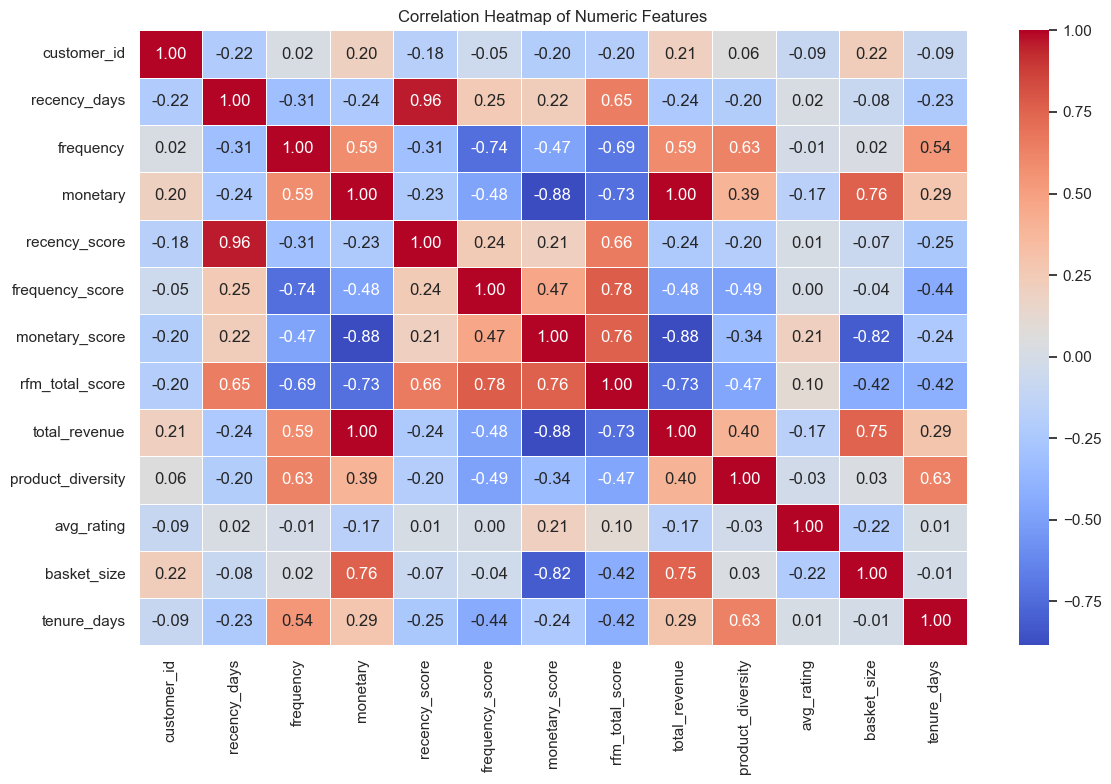

In [20]:
# Select only numeric columns
numeric_cols = mart_rfm.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
#plt.savefig('../image/Correlation Heatmap Mart_RFM.png', dpi=300)
plt.show()

#### CATEGORICAL VARIABLES

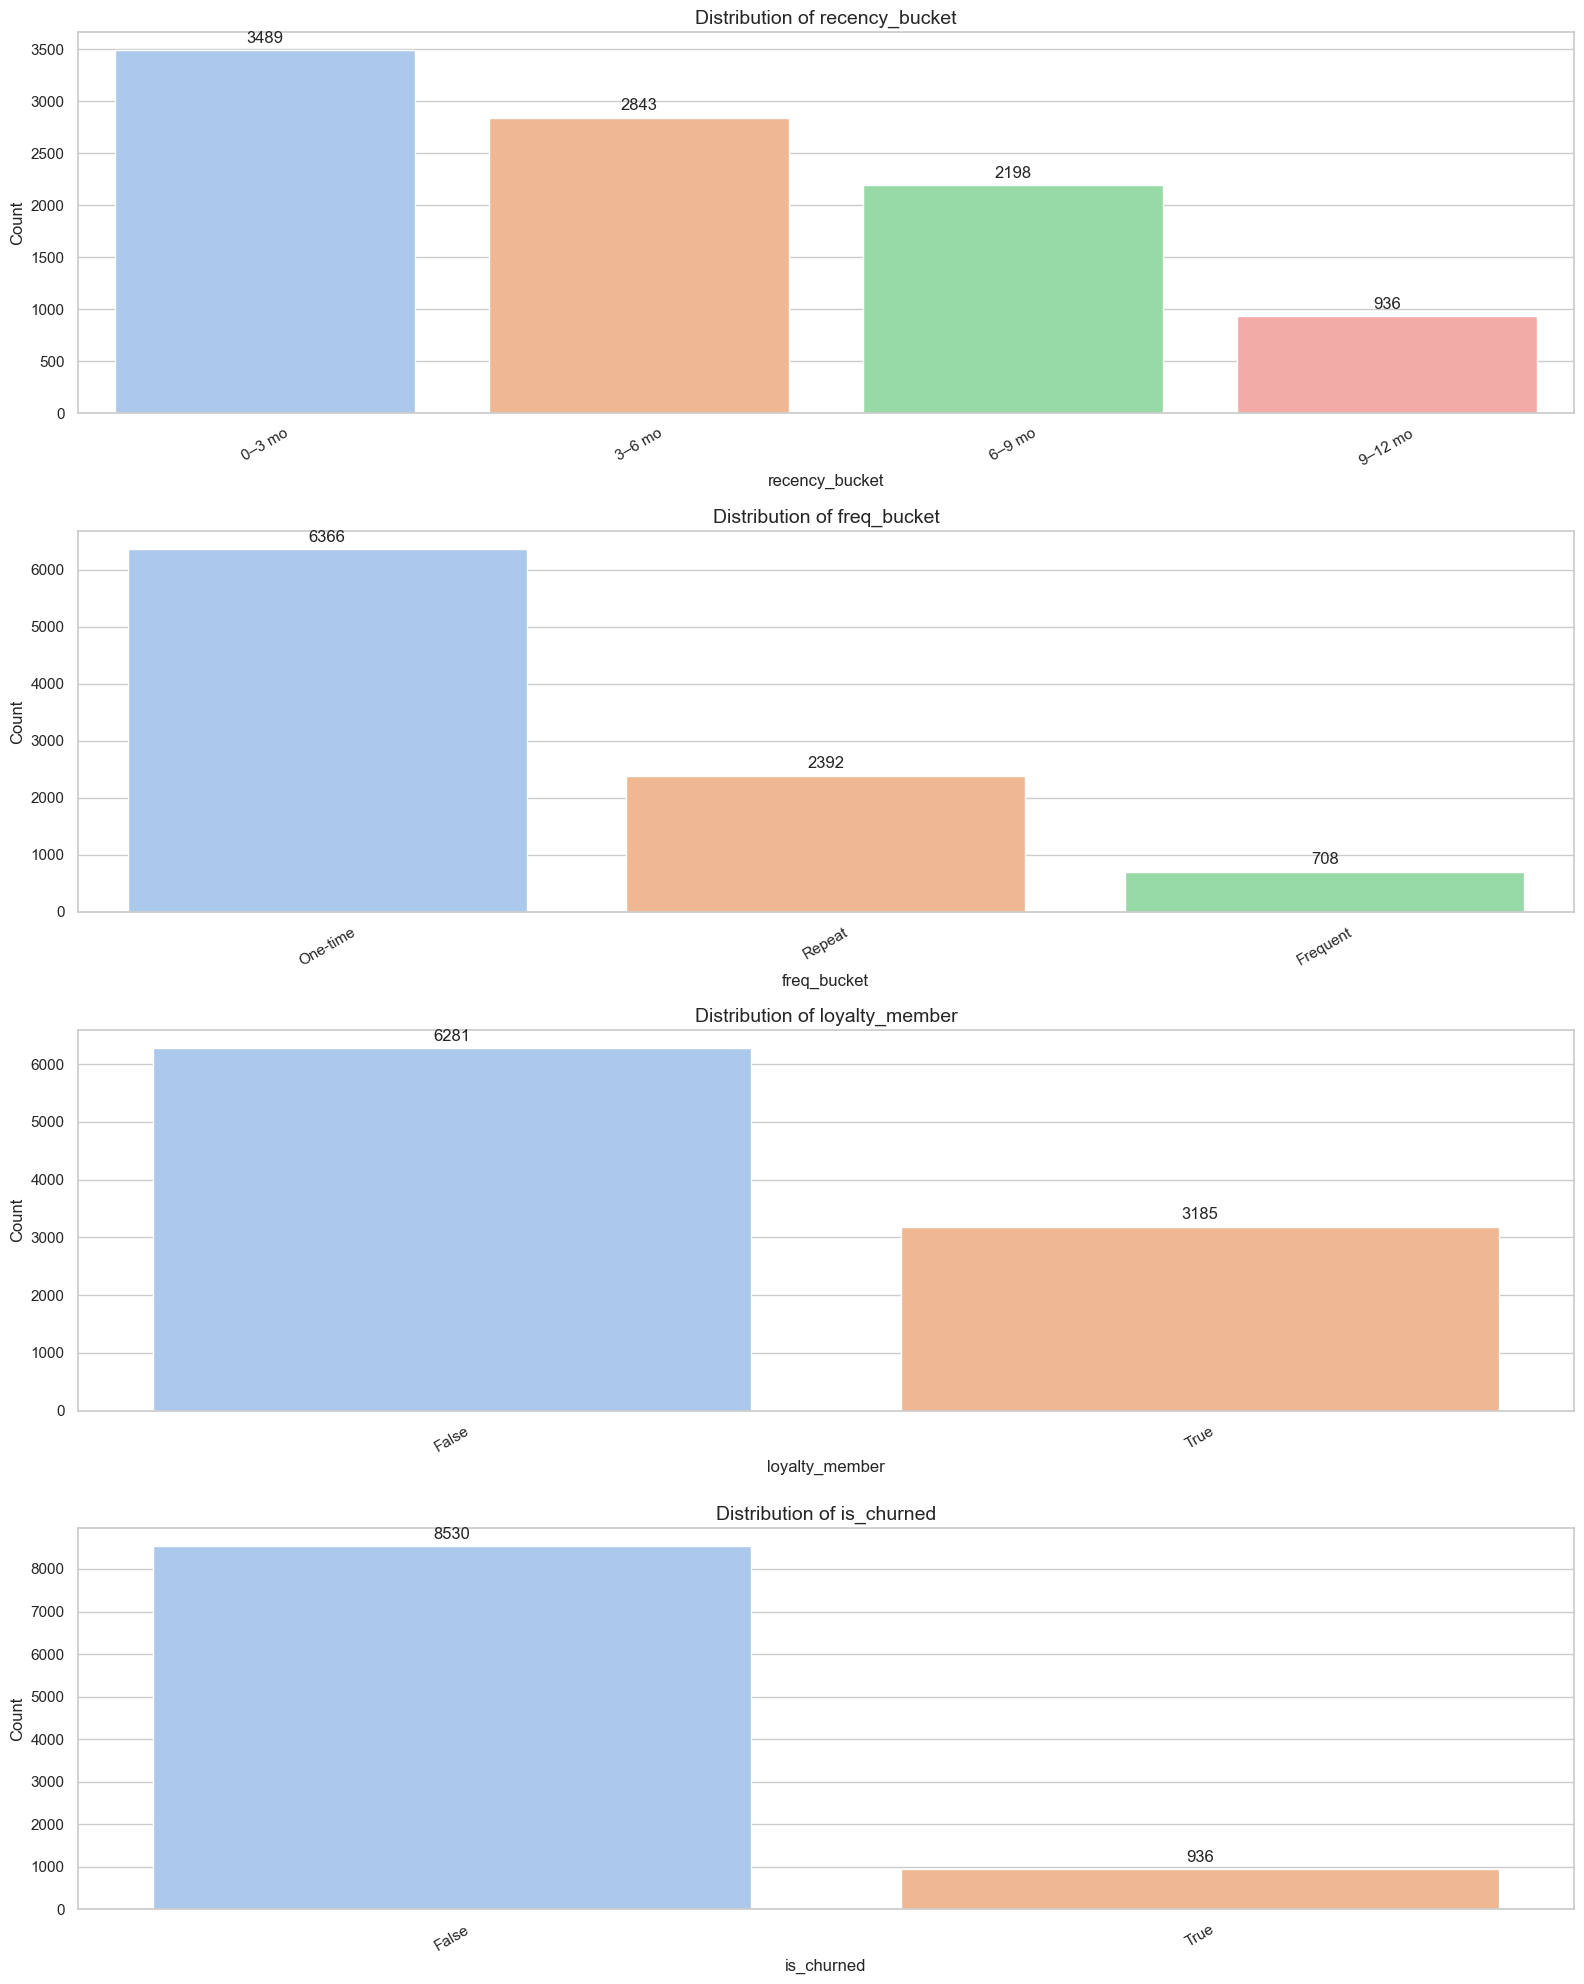

In [21]:
# List of categorical columns to check
categorical_cols = [
    'recency_bucket',
    'freq_bucket',
    'loyalty_member',
    'is_churned'
]

plt.figure(figsize=(16, 20))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    ax = sns.countplot(
        data=mart_rfm,
        x=col,
        order=mart_rfm[col].value_counts().index,
        hue=col,              
        legend=False,         
        palette="pastel"
    )
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count')
    plt.xticks(rotation=30)
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.savefig('Categorical_Features_Distribution.png', dpi=300)
plt.show()

Feature Analysis:

2. recency_bucket

    ✅ Useful: Skewed, but still has multiple groups (Old, Mid, Very Old, Recent) that might help distinguish behaviors.
    
    👀 Could be informative in churn prediction or cohort analysis.

3. freq_bucket

    ⚠️ Weakly Useful: Highly imbalanced — Low dominates (8758 vs. 19 for High).
    
    ❗ Since this is high imbalance we can drop this and as it is a derived categorical from frequency, so we already capturing

   frequency via frequency_score or frequency raw. It has dominant class imbalance, meaning it adds little value to clustering or

   segmentation.Therefore, we  can safely drop freq_bucket from modeling.

5. is_loyal

    ✅ Useful: Decent balance (6281 False vs 3185 True).
    
    🎯 Useful as a target or segment feature in loyalty prediction or lifetime value modeling.

6. is_churned

    ✅ Useful: Acceptable imbalance (8245 False vs 1221 True).
    
    📊 Great for binary classification (churn modeling).
    
    ⚠️ Be mindful of class imbalance, consider using stratified sampling or balancing techniques.

### FEATURES SELECTION

In [22]:
# Select Features For Later Modelling
model_features = mart_rfm[['customer_id','recency_score', 'frequency_score', 'monetary_score', 
                           'product_diversity', 'avg_rating', 'basket_size','tenure_days']]

# Show the result
model_features.head()

,customer_id,recency_score,frequency_score,monetary_score,product_diversity,avg_rating,basket_size,tenure_days
0,15639,1,1,1,2,4.00,7094.5850,77
1,2839,1,3,5,1,5.00,186.7500,0
2,1038,1,1,1,2,3.25,3744.1775,77
3,14264,1,1,1,2,2.00,6240.1700,79
4,11827,1,1,1,2,3.50,7323.7100,189


In [29]:
schema_name = "public_model"
table_name = "modelling_features"

# Ensure schema exists
with engine.begin() as conn:
    conn.execute(text(f"CREATE SCHEMA IF NOT EXISTS {schema_name};"))

# Check if table exists
with engine.begin() as conn:
    table_exists = conn.execute(text(f"""
        SELECT EXISTS (
            SELECT 1
            FROM information_schema.tables
            WHERE table_schema = '{schema_name}'
            AND table_name = '{table_name}'
        );
    """)).scalar()

    if table_exists:
        # Truncate if exists
        conn.execute(text(f"TRUNCATE TABLE {schema_name}.{table_name};"))
    else:
        # Create the table explicitly with your desired column types
        conn.execute(text(f"""
            CREATE TABLE {schema_name}.{table_name} (
                customer_id INT,
                recency_score INT,
                frequency_score INT,
                monetary_score INT,
                product_diversity INT,
                avg_rating FLOAT,
                basket_size FLOAT,
                tenure_days INT
            );
        """))

# Now insert fresh data
model_features.to_sql(
    table_name,
    engine,
    schema=schema_name,
    if_exists="append",   
    index=False
)

print(f"Saved {len(model_features)} rows into {schema_name}.{table_name}")

Saved 9466 rows into public_model.modelling_features


In [23]:
# Go one level up from the current directory (where the notebook is)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Construct the full path to the existing 'dataset' folder
save_path = os.path.join(parent_dir, "dataset", "model_features.csv")

# Save the DataFrame
model_features.to_csv(save_path, index=False)

print(f"model_features successfully saved to:\n{save_path}")

model_features successfully saved to:
/Users/dazieldang/Desktop/Project/Electronic-RFM/dataset/model_features.csv


In [24]:
# Go one level up from the current directory (where the notebook is)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Construct the full path to the existing 'dataset' folder
save_path = os.path.join(parent_dir, "dataset", "rfm_df.csv")

# Save the DataFrame
mart_rfm.to_csv(save_path, index=False)

print(f"model_features successfully saved to:\n{save_path}")

model_features successfully saved to:
/Users/dazieldang/Desktop/Project/Electronic-RFM/dataset/rfm_df.csv


In [26]:
# Save DataFrame into Postgres
mart_rfm.to_sql(
    "rfm_df",   
    engine,
    schema="public_analytics", 
    if_exists="replace",   
    index=False
)

print("Saved model_features → Postgres table public_analytics.rfm_df")

Saved model_features → Postgres table public_analytics.rfm_df
